In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical



from tqdm.notebook import tqdm
import plotly.express as px
plt.style.use("seaborn-colorblind")

In [2]:
df = pd.read_csv('/kaggle/input/asl-signs/train.csv')

In [3]:
sub_df = df[df['sign'].isin(['cat', 'bug'])]

In [4]:
sub_df

,path,participant_id,sequence_id,sign
102,train_landmark_files/16069/1004211348.parquet,16069,1004211348,bug
128,train_landmark_files/26734/1005029875.parquet,26734,1005029875,bug
176,train_landmark_files/27610/1006973536.parquet,27610,1006973536,bug
209,train_landmark_files/18796/1008404042.parquet,18796,1008404042,bug
260,train_landmark_files/16069/1010611404.parquet,16069,1010611404,bug
...,...,...,...,...
93691,train_landmark_files/32319/967116416.parquet,32319,967116416,cat
93757,train_landmark_files/27610/969860492.parquet,27610,969860492,cat
93996,train_landmark_files/29302/98042717.parquet,29302,98042717,bug
94033,train_landmark_files/53618/981639931.parquet,53618,981639931,cat


# **EDA : Exploratory Data Analysis** 

In [5]:
sub_df.to_csv('sub_df.csv', index=False)

In [6]:
# number of unique signs
sub_df["sign"].value_counts()

cat    400
bug    387
Name: sign, dtype: int64

Text(0, 0.5, 'Signs')

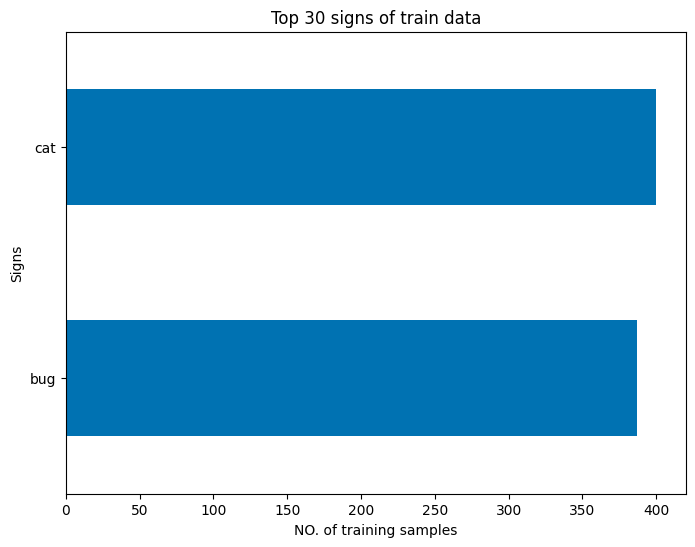

In [7]:
sub_df["sign"].value_counts().head(30).sort_values().plot(
    kind="barh", figsize=(8, 6), title="Top 30 signs of train data"
)
plt.xlabel("NO. of training samples")
plt.ylabel("Signs")

This code snippet generates a horizontal bar plot that displays the frequency count of the top 30 sign classes in the dataset. The plot is created using the plot() method from Pandas, with the argument kind="barh" to specify the plot type as a horizontal bar plot. The plot size is specified using figsize=(8, 6). The plot title is set using title="Top 30 signs of train data". The x and y-axis labels are set using plt.xlabel("NO. of training samples") and plt.ylabel("Signs"), respectively. The value_counts() method is used to count the frequency of each unique sign class, head(30) is used to select the top 30 sign classes by frequency, and sort_values() is used to sort the sign classes in ascending order by frequency.

Text(0, 0.5, 'Signs')

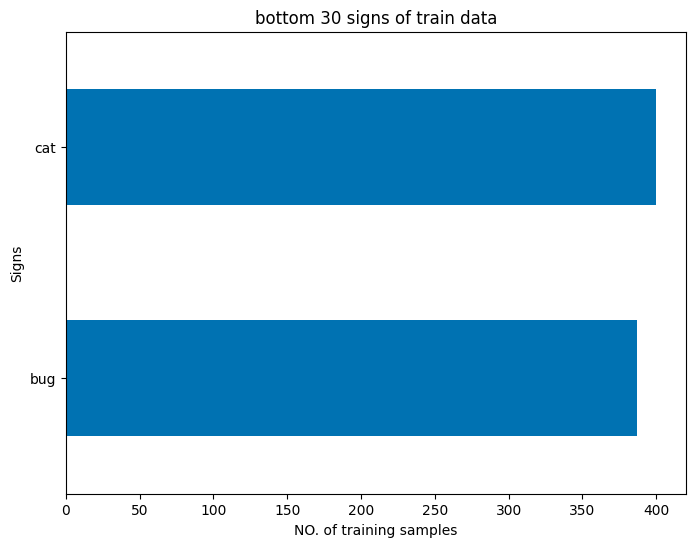

In [8]:
sub_df["sign"].value_counts().tail(30).sort_values().plot(
    kind="barh", figsize=(8, 6), title="bottom 30 signs of train data"
)
plt.xlabel("NO. of training samples")
plt.ylabel("Signs")

The second code snippet generates a similar plot, but this time for the bottom 30 sign classes in the dataset. The tail(30) method is used to select the bottom 30 sign classes by frequency.

Since the bug have less training samples compared to cat, we can do **Data Augmentation** to generate more data !

# Analysing Single Parquet file
  **for sign = "cat"**

In [9]:
p1 = sub_df.query("sign == 'cat'")["path"].iloc[0]

In [10]:
p1

'train_landmark_files/2044/101647228.parquet'

In [11]:
root_dir = "/kaggle/input/asl-signs/"

In [12]:
p1_file = pd.read_parquet(root_dir + p1)

In [13]:
frames = p1_file["frame"]
types = p1_file["type"]

print("frame:\n", frames.value_counts())
print(f"this file has {frames.nunique()} unique frames \n")
print("type:\n", types.value_counts())
print(f"this file has {types.nunique()} unique types")

frame:
 21    543
22    543
23    543
24    543
25    543
26    543
27    543
28    543
29    543
30    543
31    543
Name: frame, dtype: int64
this file has 11 unique frames 

type:
 face          5148
pose           363
left_hand      231
right_hand     231
Name: type, dtype: int64
this file has 4 unique types


This code reads the "frame" and "type" columns from the "p1_file" dataframe and prints some information about the unique values and their counts in each column.

The first line assigns the "frame" column to the "frames" variable and the "type" column to the "types" variable.

The second line prints the counts of each unique value in the "frames" column using the "value_counts()" method. This provides an overview of how frequently each unique value appears in the "frames" column.

The third line prints the number of unique values in the "frames" column using the "nunique()" method.

The fourth line prints the counts of each unique value in the "types" column using the "value_counts()" method.

The fifth line prints the number of unique values in the "types" column using the "nunique()" method.

The output is showing the number of occurrences of each frame and type in the subset of data that contains only the "cat" sign.

For the "frame" column, there are 11 unique frames (frame numbers 21 to 31), and each frame has 543 samples.

For the "type" column, there are 4 unique types: "face", "pose", "left_hand", and "right_hand". The "face" type is the most frequent with 5148 samples, followed by "pose" with 363 samples, "left_hand" with 231 samples, and "right_hand" with 231 samples.

The "frame" column represents the frame number in the raw video where the landmark data was extracted, and it can be used to identify the time when the sign was performed by the candidate. In this case, the sub dataset only includes landmark data for signs of cats, so the output is showing the number of samples in each of the 11 frames where the cat sign was performed.

# Metadata for training

Counting the number of occurrences of each type of hand pose in the selected ASL sign language gesture file (specified by the p1 variable) {for cat and bug}

In [14]:
p1_file["type"].value_counts()

face          5148
pose           363
left_hand      231
right_hand     231
Name: type, dtype: int64

Counting the number of occurrences of each type of hand pose in the selected ASL sign language gesture file that has non-null values for the x, y, and z coordinates of each hand landmark.

In [15]:
p1_file.dropna(subset=["x", "y", "z"])["type"].value_counts()


face          5148
pose           363
right_hand     105
Name: type, dtype: int64

The following loop  is then used to iterate through each row of the selected subset of the ASL sign language dataset (sub_df) and for each row, the following actions are performed:

1. Reading in the corresponding ASL sign language gesture file specified by the path column of the current row.

2. Counting the number of non-null x, y, and z coordinates for each hand pose type in the current file using the dropna method and creating a dictionary (meta) that stores this information along with the number of unique frames in the file.

3. Calculating summary statistics (minimum, maximum, and mean) for the x, y, and z coordinates of each hand landmark in the current file and storing these statistics in the meta dictionary.

4. Storing the meta dictionary in another dictionary (metadata) with the current file's path as the key.

In [16]:
new_data = []
for i, d in tqdm(sub_df.iterrows(), total=len(sub_df)):
    file_path = d["path"]
    parquet_file = pd.read_parquet(root_dir + file_path)
    new_data.append(parquet_file)

df = pd.concat(new_data) # Combine all Parquet files into one DataFrame
grouped_data = df.groupby(['type', 'landmark_index']).mean().reset_index() # Groupby 'type' and 'landmark' and calculate mean


  0%|          | 0/787 [00:00<?, ?it/s]

In [17]:
grouped_data

,type,landmark_index,frame,x,y,z
0,face,0,79.172134,0.464208,0.466355,-0.043368
1,face,1,79.172134,0.459604,0.427550,-0.071094
2,face,2,79.172134,0.460937,0.439920,-0.040278
3,face,3,79.172134,0.448032,0.394762,-0.049016
4,face,4,79.172134,0.459171,0.416749,-0.074382
...,...,...,...,...,...,...
538,right_hand,16,79.172134,0.345425,0.516734,-0.094048
539,right_hand,17,79.172134,0.251005,0.565197,-0.085401
540,right_hand,18,79.172134,0.295643,0.552971,-0.106326
541,right_hand,19,79.172134,0.307522,0.553357,-0.102861


In [18]:
X = grouped_data[['x', 'y', 'z']]
y = grouped_data['type']

In [19]:
# Calculate the number of labeled samples
n_labeled = int(0.01 * len(grouped_data)) # 1% of the total samples

# Calculate the number of unlabeled samples
n_unlabeled = len(grouped_data) - n_labeled

indices = np.arange(len(X))
rng = np.random.RandomState(42)
rng.shuffle(indices)

X_labeled = X.iloc[indices[:n_labeled]]
y_labeled = y.iloc[indices[:n_labeled]]
X_unlabeled = X.iloc[indices[n_labeled:]]
y_unlabeled = y.iloc[indices[n_labeled:]]
X_unlabeled = X_unlabeled.reset_index(drop=True)
y_unlabeled = y_unlabeled.reset_index(drop=True)

n_iterations = 10
n_samples_per_iter = 10

train_accuracy_list = []
test_accuracy_list = []

# Split the unlabeled dataset into a test set and a smaller unlabeled set
X_test, X_unlabeled, y_test, y_unlabeled = train_test_split(X_unlabeled, y_unlabeled, test_size=0.3)


# Active Learning usign SVM 

These code blocks are used to create and train a Support Vector Machine (SVM) classifier. 

The first line creates an instance of an SVM classifier with the "probability" parameter set to "True". This means that the classifier will be able to output probability estimates for each class in addition to the predicted class.

The second line trains the classifier using the labeled dataset X_labeled and y_labeled. This is done using the "fit" method, which fits the SVM to the data and determines the decision boundary that separates the different classes. Once the SVM is trained, it can be used to make predictions on new, unlabeled data.

In [20]:

# Create an SVM classifier
clf = SVC(probability=True)


# Train the classifier on the initial labeled set
clf.fit(X_labeled, y_labeled)


SVC(probability=True)

These code blocks are used to create a pipeline that includes a StandardScaler for feature scaling, an SVM classifier with RBF kernel, and L2 regularization. The pipeline is then used for hyperparameter tuning using GridSearchCV.

The first line creates the pipeline using the "make_pipeline" function from Scikit-Learn. The pipeline includes a StandardScaler, which scales the features to have zero mean and unit variance, and an SVM classifier with an RBF kernel. The "probability" parameter is set to "True" to allow for probability estimates, and the "class_weight" parameter is set to "balanced" to account for class imbalance. The "random_state" parameter is set to 42 for reproducibility.

The second line sets up the parameter grid for the hyperparameter tuning using GridSearchCV. The "C" parameter and "gamma" parameter are both varied over a range of values to find the optimal combination of hyperparameters.

The third line creates a GridSearchCV object, which takes the pipeline and parameter grid as input. The "cv" parameter is set to 5 for 5-fold cross-validation. The GridSearchCV object then searches over the specified hyperparameter space using cross-validation to determine the optimal hyperparameters for the SVM classifier in the pipeline.

In [21]:
# Create a pipeline with L2 regularization and SVM classifier
pipeline = make_pipeline(StandardScaler(), SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42))

# Set up the parameter grid for grid search
param_grid = {'svc__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svc__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

# Create the grid search object
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=2)


These code blocks define two functions for measuring uncertainty in a set of predicted probabilities.

The first function, "least_confident", takes a matrix of predicted probabilities as input and returns an array of values that represent the least confident prediction for each instance in the input. This is done by taking the maximum probability for each instance and subtracting it from 1, which gives the probability of the least confident prediction.

The second function, "entropy", also takes a matrix of predicted probabilities as input and returns an array of values that represent the entropy of the predicted probabilities for each instance in the input. This is done by taking the sum of the product of each probability and its logarithm (with a small epsilon added to avoid numerical instability), and negating the result. The intuition behind this measure is that higher entropy indicates greater uncertainty in the predicted probabilities, since the probabilities are more evenly spread across the classes.

In [22]:
def least_confident(proba):
    return 1 - np.max(proba, axis=1)

def entropy(proba):
    return -np.sum(proba * np.log2(proba + 1e-10), axis=1)

This code block defines a function that implements an active learning loop using a specified query strategy. The function takes as input the following:

- The query strategy to use (which should be a function that takes a matrix of predicted probabilities and returns an array of uncertainty scores).
- The initial labeled set (as X_labeled and y_labeled).
- The initial unlabeled set (as X_unlabeled and y_unlabeled).
- The test set (as X_test and y_test).
- The number of iterations to run (as n_iterations).
- The number of samples to select per iteration (as n_samples_per_iter).

The function then iteratively selects the n_samples_per_iter samples from the unlabeled set with the highest uncertainty scores using the specified query strategy. It then adds these samples to the labeled set and retrains the classifier on the updated labeled set. After each iteration, the function calculates the accuracy of the classifier on both the training set and the test set and stores these values in lists for plotting. If there are no more unlabeled samples to select, the function stops early and prints a message.

Finally, the function plots the accuracy values for each iteration of the active learning loop.

It should be noted that this code block assumes that the grid_search and clf objects have already been defined and that the train_accuracy_list and test_accuracy_list arrays have already been initialized outside of the function.

In [23]:
def active_learning_loop(query_strategy, X_labeled, y_labeled, X_unlabeled, y_unlabeled, X_test, y_test, n_iterations, n_samples_per_iter, test_accuracy_list):
    
    # Calculate the initial percentage of labeled data
    initial_percentage_labeled = len(X_labeled) / (len(X_labeled) + len(X_unlabeled))

    for i in range(n_iterations):
        if len(X_unlabeled) == 0:
            print("No more unlabeled samples to select.")
            break

        # Train the classifier on the initial labeled set
        grid_search.fit(X_labeled, y_labeled)

        # Get the best estimator from the grid search
        clf = grid_search.best_estimator_

        # Predict the labels and probabilities for the test and unlabeled sets
        y_pred_test = clf.predict(X_test)
        y_proba_unlabeled = clf.predict_proba(X_unlabeled)

        # Calculate uncertainty scores using the least confident method
        uncertainty_scores = 1 - np.max(y_proba_unlabeled, axis=1)

        # Select samples with the highest uncertainty scores
        selected_indices = np.argsort(-uncertainty_scores)[:n_samples_per_iter]

        # Add selected samples to the labeled set
        X_labeled = pd.concat([X_labeled, X_unlabeled.iloc[selected_indices]])
        y_labeled = pd.concat([y_labeled, y_unlabeled.iloc[selected_indices]])

        # Remove selected samples from the unlabeled set
        X_unlabeled = X_unlabeled.drop(X_unlabeled.index[selected_indices])
        y_unlabeled = y_unlabeled.drop(y_unlabeled.index[selected_indices])
        X_unlabeled = X_unlabeled.reset_index(drop=True)
        y_unlabeled = y_unlabeled.reset_index(drop=True)

        # Retrain the classifier on the updated labeled set
        clf.fit(X_labeled, y_labeled)

        # Check the performance of the classifier on the training set
        y_pred_train = clf.predict(X_labeled)
        train_accuracy = accuracy_score(y_labeled, y_pred_train)
        train_accuracy_list.append(train_accuracy)

        # Check the performance of the classifier on the test set
        y_pred_test = clf.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_pred_test)
        test_accuracy_list.append(test_accuracy)

        # Calculate the percentage of labeled data
        percentage_labeled = len(X_labeled) / (len(X_labeled) + len(X_unlabeled))

        print(f"Iteration {i + 1}: Percentage of Labeled Data = {percentage_labeled:.2%}, Train Accuracy = {train_accuracy:.2f}, Test Accuracy = {test_accuracy:.2f}")

    if len(X_unlabeled) > 0:
        print("Stopped before all iterations completed: No more unlabeled samples to select.")
        


In [24]:
# Reset the train_accuracy_list and test_accuracy_list before each call
train_accuracy_list_svm = []
test_accuracy_list_svm = []

# Call the active_learning_loop function for each query strategy
active_learning_loop('entropy', X_labeled, y_labeled, X_unlabeled, y_unlabeled, X_test, y_test, n_iterations, n_samples_per_iter, test_accuracy_list_svm)

test_accuracy_list_1_svm = test_accuracy_list_svm.copy()

# Reset the train_accuracy_list and test_accuracy_list before each call
train_accuracy_list_svm = []
test_accuracy_list_svm = []

active_learning_loop('least_confident', X_labeled, y_labeled, X_unlabeled, y_unlabeled, X_test, y_test, n_iterations, n_samples_per_iter, test_accuracy_list_svm)

test_accuracy_list_2_svm = test_accuracy_list_svm.copy()


Iteration 1: Percentage of Labeled Data = 8.98%, Train Accuracy = 0.40, Test Accuracy = 0.10
Iteration 2: Percentage of Labeled Data = 14.97%, Train Accuracy = 0.96, Test Accuracy = 0.82
Iteration 3: Percentage of Labeled Data = 20.96%, Train Accuracy = 0.63, Test Accuracy = 0.86
Iteration 4: Percentage of Labeled Data = 26.95%, Train Accuracy = 1.00, Test Accuracy = 0.99
Iteration 5: Percentage of Labeled Data = 32.93%, Train Accuracy = 0.96, Test Accuracy = 0.95
Iteration 6: Percentage of Labeled Data = 38.92%, Train Accuracy = 0.98, Test Accuracy = 0.99
Iteration 7: Percentage of Labeled Data = 44.91%, Train Accuracy = 0.99, Test Accuracy = 0.99
Iteration 8: Percentage of Labeled Data = 50.90%, Train Accuracy = 0.99, Test Accuracy = 0.99
Iteration 9: Percentage of Labeled Data = 56.89%, Train Accuracy = 1.00, Test Accuracy = 1.00
Iteration 10: Percentage of Labeled Data = 62.87%, Train Accuracy = 1.00, Test Accuracy = 1.00
Stopped before all iterations completed: No more unlabeled s

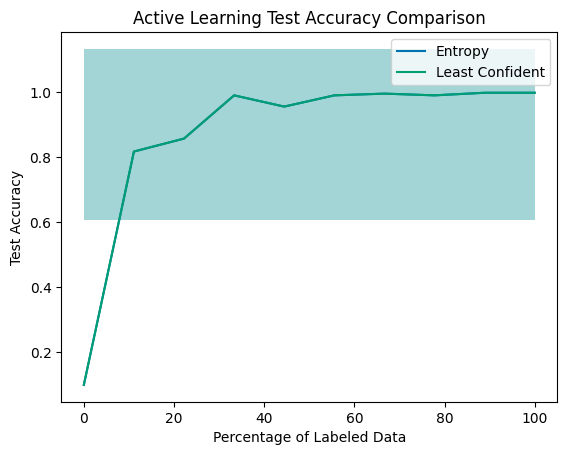

In [25]:
# Calculate mean and standard deviation for each strategy
mean_test_accuracy_1 = np.mean(test_accuracy_list_1_svm)
std_test_accuracy_1 = np.std(test_accuracy_list_1_svm)

mean_test_accuracy_2 = np.mean(test_accuracy_list_2_svm)
std_test_accuracy_2 = np.std(test_accuracy_list_2_svm)

# Create x-axis values for plotting
x_values = np.linspace(0, 100, num=len(test_accuracy_list_1_svm))

# Create upper and lower bounds for shading
upper_entropy = mean_test_accuracy_1 + std_test_accuracy_1
lower_entropy = mean_test_accuracy_1 - std_test_accuracy_1
upper_least_confident = mean_test_accuracy_2 + std_test_accuracy_2
lower_least_confident = mean_test_accuracy_2 - std_test_accuracy_2

# Plot mean test accuracies and shade area between upper and lower bounds for each strategy
plt.plot(x_values, test_accuracy_list_1_svm, label='Entropy')
plt.fill_between(x_values, lower_entropy, upper_entropy, alpha=0.2)
plt.plot(x_values, test_accuracy_list_2_svm, label='Least Confident')
plt.fill_between(x_values, lower_least_confident, upper_least_confident, alpha=0.2)

# Set plot title, axis labels, and legend
plt.title('Active Learning Test Accuracy Comparison')
plt.xlabel('Percentage of Labeled Data')
plt.ylabel('Test Accuracy')
plt.legend()

# Show plot
plt.show()


# Active Learning with RandomForestClassifier

This code block creates a `RandomForestClassifier` object and trains it on the initial labeled data `X_labeled` and `y_labeled` using the `fit` method. The `RandomForestClassifier` is an ensemble learning method that combines multiple decision trees to produce a more accurate and robust model. The `random_state` parameter is set to 42 to ensure reproducibility of the results.

In [26]:
# Create a Random Forest classifier
clf = RandomForestClassifier(random_state=42)


# Train the classifier on the initial labeled set
clf.fit(X_labeled, y_labeled)


RandomForestClassifier(random_state=42)

This code block creates a pipeline object that chains two transformers: `StandardScaler` and `RandomForestClassifier` using the `make_pipeline` function. 

The `StandardScaler` is used to standardize the input data by subtracting the mean and dividing by the standard deviation. The `RandomForestClassifier` is an ensemble learning method that combines multiple decision trees to produce a more accurate and robust model. The `random_state` parameter is set to 42 to ensure reproducibility of the results.

The `param_grid` dictionary specifies the hyperparameters to be tuned using grid search cross-validation. The `n_estimators` hyperparameter controls the number of decision trees in the forest, and the `max_depth` hyperparameter controls the maximum depth of each tree.

The `GridSearchCV` object is created to perform the grid search with 5-fold cross-validation, and it will search over all combinations of hyperparameters specified in `param_grid`.

In [27]:
# Create a pipeline with StandardScaler and Random Forest classifier
pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=42))

# Set up the parameter grid for grid search
param_grid = {'randomforestclassifier__n_estimators': [10, 50, 100, 200, 500],
              'randomforestclassifier__max_depth': [None, 5, 10, 20, 50]}

# Create the grid search object
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=2)


Here we are again with the active learning loop, but this time we replace the SVM classifier with the RandomForestClassifier 

In [28]:
def active_learning_loop(query_strategy, X_labeled, y_labeled, X_unlabeled, y_unlabeled, X_test, y_test, n_iterations, n_samples_per_iter, test_accuracy_list):
    
    # Calculate the initial percentage of labeled data
    initial_percentage_labeled = len(X_labeled) / (len(X_labeled) + len(X_unlabeled))

    for i in range(n_iterations):
        if len(X_unlabeled) == 0:
            print("No more unlabeled samples to select.")
            break

        # Train the classifier on the initial labeled set
        grid_search.fit(X_labeled, y_labeled)

        # Get the best estimator from the grid search
        clf = grid_search.best_estimator_

        # Predict the labels and probabilities for the test and unlabeled sets
        y_pred_test = clf.predict(X_test)
        y_proba_unlabeled = clf.predict_proba(X_unlabeled)

        # Calculate uncertainty scores using the least confident method
        uncertainty_scores = 1 - np.max(y_proba_unlabeled, axis=1)

        # Select samples with the highest uncertainty scores
        selected_indices = np.argsort(-uncertainty_scores)[:n_samples_per_iter]

        # Add selected samples to the labeled set
        X_labeled = pd.concat([X_labeled, X_unlabeled.iloc[selected_indices]])
        y_labeled = pd.concat([y_labeled, y_unlabeled.iloc[selected_indices]])

        # Remove selected samples from the unlabeled set
        X_unlabeled = X_unlabeled.drop(X_unlabeled.index[selected_indices])
        y_unlabeled = y_unlabeled.drop(y_unlabeled.index[selected_indices])
        X_unlabeled = X_unlabeled.reset_index(drop=True)
        y_unlabeled = y_unlabeled.reset_index(drop=True)

        # Retrain the classifier on the updated labeled set
        clf.fit(X_labeled, y_labeled)

        # Check the performance of the classifier on the training set
        y_pred_train = clf.predict(X_labeled)
        train_accuracy = accuracy_score(y_labeled, y_pred_train)
        train_accuracy_list.append(train_accuracy)

        # Check the performance of the classifier on the test set
        y_pred_test = clf.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_pred_test)
        test_accuracy_list.append(test_accuracy)

        # Calculate the percentage of labeled data
        percentage_labeled = len(X_labeled) / (len(X_labeled) + len(X_unlabeled))

        print(f"Iteration {i + 1}: Percentage of Labeled Data = {percentage_labeled:.2%}, Train Accuracy = {train_accuracy:.2f}, Test Accuracy = {test_accuracy:.2f}")

    if len(X_unlabeled) > 0:
        print("Stopped before all iterations completed: No more unlabeled samples to select.")
        


Here's the call for the active learning loop for both queries : 'entropy' and 'least_confident'

In [29]:
# Reset the train_accuracy_list and test_accuracy_list before each call
train_accuracy_list = []
test_accuracy_list = []

# Call the active_learning_loop function for each query strategy
active_learning_loop('entropy', X_labeled, y_labeled, X_unlabeled, y_unlabeled, X_test, y_test, n_iterations, n_samples_per_iter, test_accuracy_list)

test_accuracy_list_1 = test_accuracy_list.copy()

# Reset the train_accuracy_list and test_accuracy_list before each call
train_accuracy_list = []
test_accuracy_list = []

active_learning_loop('least_confident', X_labeled, y_labeled, X_unlabeled, y_unlabeled, X_test, y_test, n_iterations, n_samples_per_iter, test_accuracy_list)

test_accuracy_list_2 = test_accuracy_list.copy()


Iteration 1: Percentage of Labeled Data = 8.98%, Train Accuracy = 1.00, Test Accuracy = 0.92
Iteration 2: Percentage of Labeled Data = 14.97%, Train Accuracy = 1.00, Test Accuracy = 0.96
Iteration 3: Percentage of Labeled Data = 20.96%, Train Accuracy = 1.00, Test Accuracy = 0.98
Iteration 4: Percentage of Labeled Data = 26.95%, Train Accuracy = 1.00, Test Accuracy = 0.97
Iteration 5: Percentage of Labeled Data = 32.93%, Train Accuracy = 1.00, Test Accuracy = 0.96
Iteration 6: Percentage of Labeled Data = 38.92%, Train Accuracy = 1.00, Test Accuracy = 0.97
Iteration 7: Percentage of Labeled Data = 44.91%, Train Accuracy = 1.00, Test Accuracy = 0.95
Iteration 8: Percentage of Labeled Data = 50.90%, Train Accuracy = 1.00, Test Accuracy = 0.97
Iteration 9: Percentage of Labeled Data = 56.89%, Train Accuracy = 1.00, Test Accuracy = 0.96
Iteration 10: Percentage of Labeled Data = 62.87%, Train Accuracy = 1.00, Test Accuracy = 0.97
Stopped before all iterations completed: No more unlabeled s

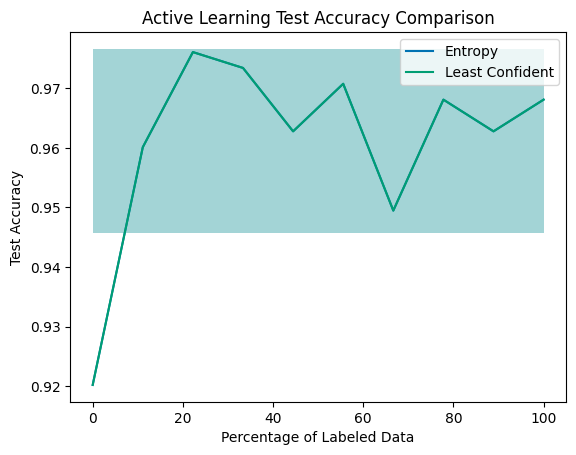

In [30]:


# Calculate mean and standard deviation for each strategy
mean_test_accuracy_1 = np.mean(test_accuracy_list_1)
std_test_accuracy_1 = np.std(test_accuracy_list_1)

mean_test_accuracy_2 = np.mean(test_accuracy_list_2)
std_test_accuracy_2 = np.std(test_accuracy_list_2)

# Create x-axis values for plotting
x_values = np.linspace(0, 100, num=len(test_accuracy_list_1))

# Create upper and lower bounds for shading
upper_entropy = mean_test_accuracy_1 + std_test_accuracy_1
lower_entropy = mean_test_accuracy_1 - std_test_accuracy_1
upper_least_confident = mean_test_accuracy_2 + std_test_accuracy_2
lower_least_confident = mean_test_accuracy_2 - std_test_accuracy_2

# Plot mean test accuracies and shade area between upper and lower bounds for each strategy
plt.plot(x_values, test_accuracy_list_1, label='Entropy')
plt.fill_between(x_values, lower_entropy, upper_entropy, alpha=0.2)
plt.plot(x_values, test_accuracy_list_2, label='Least Confident')
plt.fill_between(x_values, lower_least_confident, upper_least_confident, alpha=0.2)

# Set plot title, axis labels, and legend
plt.title('Active Learning Test Accuracy Comparison')
plt.xlabel('Percentage of Labeled Data')
plt.ylabel('Test Accuracy')
plt.legend()

# Show plot
plt.show()


# Active Learning with Neural Networks (MLPClassifier)

**MLPClassifier** is a class in the scikit-learn library used for implementing a Multi-layer Perceptron (MLP) neural network. An MLP is a feedforward artificial neural network that is commonly used for classification tasks. The MLPClassifier allows the user to specify various hyperparameters such as the number of hidden layers, the number of neurons in each hidden layer, the activation function, the solver for weight optimization, and regularization parameters. It uses backpropagation to train the network by adjusting the weights to minimize the error between the predicted and actual outputs. Once trained, the MLP can be used to predict the class labels of new data.

This is a function definition for an active learning loop that performs iterative model training and query selection to improve the accuracy of a machine learning model. The function takes in several arguments:

- `query_strategy`: a string indicating the method for selecting the most informative samples to label at each iteration. The options are 'least_confident' or 'entropy'.
- `X_labeled`: a pandas dataframe containing the features of the labeled data.
- `y_labeled`: a pandas series containing the labels of the labeled data.
- `X_unlabeled`: a pandas dataframe containing the features of the unlabeled data.
- `y_unlabeled`: a pandas series containing the labels of the unlabeled data.
- `X_test`: a pandas dataframe containing the features of the test data.
- `y_test`: a pandas series containing the labels of the test data.
- `n_iterations`: an integer indicating the number of iterations to run the active learning loop.
- `n_samples_per_iter`: an integer indicating the number of samples to select and label at each iteration.

The function uses a multi-layer perceptron (MLP) classifier with a grid search over hyperparameters to fit the model to the labeled data at each iteration. It then uses the chosen query strategy to select the most informative samples from the unlabeled data and adds them to the labeled data for the next iteration. The accuracy scores of the model on the training and test data are calculated and stored for each iteration, and the function returns the lists of these accuracy scores, as well as the best test accuracy score and hyperparameters found during the iterations.

In [31]:
def active_learning_loop(query_strategy, X_labeled, y_labeled, X_unlabeled, y_unlabeled, X_test, y_test, n_iterations, n_samples_per_iter, test_accuracy_list):
    #train_accuracy_list = []
    #test_accuracy_list = []
    best_score = 0
    best_params = None
    
    # Calculate the initial percentage of labeled data
    initial_percentage_labeled = len(X_labeled) / (len(X_labeled) + len(X_unlabeled))
    
    for i in range(n_iterations):
        clf = MLPClassifier(random_state=1, max_iter=1000)
        
        # Define the parameter grid to search over
        param_grid = {
            'hidden_layer_sizes': [(32,), (64,), (128,), (32, 16), (64, 32), (128, 64)],
            'activation': ['relu', 'tanh'],
            'solver': ['adam', 'sgd'],
            'alpha': [0.0001, 0.001, 0.01, 0.1],
            'learning_rate': ['constant', 'adaptive'],
        }

        # perform a grid search over the hyperparameter grid
        from sklearn.model_selection import GridSearchCV
        grid_search = GridSearchCV(clf, param_grid=param_grid, cv=2, n_jobs=-1, verbose=1)
        grid_search.fit(X_labeled, y_labeled)
        
        # get the best model and its test accuracy score
        clf = grid_search.best_estimator_
        test_score = clf.score(X_test, y_test)
        
        # update the best model if it has the highest test accuracy score so far
        if test_score > best_score:
            best_score = test_score
            best_params = grid_search.best_params_

        # fit the model to the labeled data
        clf.fit(X_labeled, y_labeled)

        # use the query strategy to select the most informative samples
        y_proba_unlabeled = clf.predict_proba(X_unlabeled)
        if query_strategy == 'least_confident':
            uncertainty_scores = least_confident(y_proba_unlabeled)
        elif query_strategy == 'entropy':
            uncertainty_scores = entropy(y_proba_unlabeled)
        else:
            raise ValueError("Invalid query strategy")

        selected_indices = np.argsort(-uncertainty_scores)[:n_samples_per_iter]

        # add the selected samples to the labeled data
        X_labeled = pd.concat([X_labeled, X_unlabeled.iloc[selected_indices]])
        y_labeled = pd.concat([y_labeled, y_unlabeled.iloc[selected_indices]])

        # remove the selected samples from the unlabeled data
        X_unlabeled = X_unlabeled.drop(X_unlabeled.index[selected_indices])
        y_unlabeled = y_unlabeled.drop(y_unlabeled.index[selected_indices])

        # calculate and store the accuracy scores for the training and test data
        y_pred_train = clf.predict(X_labeled)
        train_accuracy = accuracy_score(y_labeled, y_pred_train)
        train_accuracy_list.append(train_accuracy)

        y_pred_test = clf.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_pred_test)
        test_accuracy_list.append(test_accuracy)
        
        # Calculate the percentage of labeled data
        percentage_labeled = len(X_labeled) / (len(X_labeled) + len(X_unlabeled))

        # print the iteration number and accuracy scores
        print(f"Iteration {i + 1}: Train Accuracy = {train_accuracy:.2f}, Test Accuracy = {test_accuracy:.2f}")



    # Return the accuracy lists after all iterations are completed
    #return train_accuracy_list, test_accuracy_list, best_score, best_params

    if len(X_unlabeled) > 0:
            print("Stopped before all iterations completed: No more unlabeled samples to select.")
   

In [32]:
# Reset the train_accuracy_list and test_accuracy_list before each call
train_accuracy_list = []
test_accuracy_list = []

# Call the active_learning_loop function for each query strategy
active_learning_loop('entropy', X_labeled, y_labeled, X_unlabeled, y_unlabeled, X_test, y_test, n_iterations, n_samples_per_iter, test_accuracy_list)

test_accuracy_list_1 = test_accuracy_list.copy()

# Reset the train_accuracy_list and test_accuracy_list before each call
train_accuracy_list = []
test_accuracy_list = []

active_learning_loop('least_confident', X_labeled, y_labeled, X_unlabeled, y_unlabeled, X_test, y_test, n_iterations, n_samples_per_iter, test_accuracy_list)

test_accuracy_list_2 = test_accuracy_list.copy()


Fitting 2 folds for each of 192 candidates, totalling 384 fits


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Iteration 1: Train Accuracy = 0.93, Test Accuracy = 0.93
Fitting 2 folds for each of 192 candidates, totalling 384 fits


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perce

Iteration 2: Train Accuracy = 1.00, Test Accuracy = 0.93
Fitting 2 folds for each of 192 candidates, totalling 384 fits


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perce

Iteration 3: Train Accuracy = 0.77, Test Accuracy = 0.89
Fitting 2 folds for each of 192 candidates, totalling 384 fits


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perce

Iteration 4: Train Accuracy = 1.00, Test Accuracy = 0.97
Fitting 2 folds for each of 192 candidates, totalling 384 fits


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perce

Iteration 5: Train Accuracy = 0.95, Test Accuracy = 0.96
Fitting 2 folds for each of 192 candidates, totalling 384 fits


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perce

Iteration 6: Train Accuracy = 0.97, Test Accuracy = 0.97
Fitting 2 folds for each of 192 candidates, totalling 384 fits


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perce

Iteration 7: Train Accuracy = 0.99, Test Accuracy = 0.97
Fitting 2 folds for each of 192 candidates, totalling 384 fits


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perce

Iteration 8: Train Accuracy = 0.99, Test Accuracy = 0.98
Fitting 2 folds for each of 192 candidates, totalling 384 fits


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perce

Iteration 9: Train Accuracy = 0.97, Test Accuracy = 0.96
Fitting 2 folds for each of 192 candidates, totalling 384 fits


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perce

Iteration 10: Train Accuracy = 0.99, Test Accuracy = 0.97
Stopped before all iterations completed: No more unlabeled samples to select.
Fitting 2 folds for each of 192 candidates, totalling 384 fits


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perce

Iteration 1: Train Accuracy = 1.00, Test Accuracy = 0.93
Fitting 2 folds for each of 192 candidates, totalling 384 fits


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perce

Iteration 2: Train Accuracy = 0.76, Test Accuracy = 0.85
Fitting 2 folds for each of 192 candidates, totalling 384 fits


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perce

Iteration 3: Train Accuracy = 0.97, Test Accuracy = 0.93
Fitting 2 folds for each of 192 candidates, totalling 384 fits


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perce

Iteration 4: Train Accuracy = 0.89, Test Accuracy = 0.94
Fitting 2 folds for each of 192 candidates, totalling 384 fits


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perce

Iteration 5: Train Accuracy = 0.96, Test Accuracy = 0.99
Fitting 2 folds for each of 192 candidates, totalling 384 fits


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perce

Iteration 6: Train Accuracy = 1.00, Test Accuracy = 0.98
Fitting 2 folds for each of 192 candidates, totalling 384 fits


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perce

Iteration 7: Train Accuracy = 0.99, Test Accuracy = 0.98
Fitting 2 folds for each of 192 candidates, totalling 384 fits


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perce

Iteration 8: Train Accuracy = 1.00, Test Accuracy = 0.98
Fitting 2 folds for each of 192 candidates, totalling 384 fits


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perce

Iteration 9: Train Accuracy = 1.00, Test Accuracy = 0.98
Fitting 2 folds for each of 192 candidates, totalling 384 fits


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perce

Iteration 10: Train Accuracy = 0.98, Test Accuracy = 0.97
Stopped before all iterations completed: No more unlabeled samples to select.


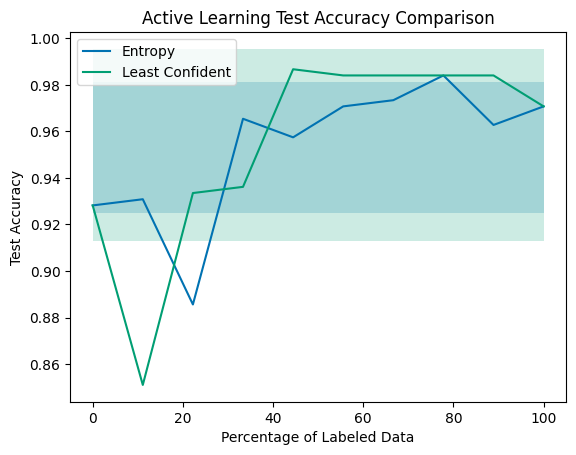

In [33]:


# Calculate mean and standard deviation for each strategy
mean_test_accuracy_1 = np.mean(test_accuracy_list_1)
std_test_accuracy_1 = np.std(test_accuracy_list_1)

mean_test_accuracy_2 = np.mean(test_accuracy_list_2)
std_test_accuracy_2 = np.std(test_accuracy_list_2)

# Create x-axis values for plotting
x_values = np.linspace(0, 100, num=len(test_accuracy_list_1))

# Create upper and lower bounds for shading
upper_entropy = mean_test_accuracy_1 + std_test_accuracy_1
lower_entropy = mean_test_accuracy_1 - std_test_accuracy_1
upper_least_confident = mean_test_accuracy_2 + std_test_accuracy_2
lower_least_confident = mean_test_accuracy_2 - std_test_accuracy_2

# Plot mean test accuracies and shade area between upper and lower bounds for each strategy
plt.plot(x_values, test_accuracy_list_1, label='Entropy')
plt.fill_between(x_values, lower_entropy, upper_entropy, alpha=0.2)
plt.plot(x_values, test_accuracy_list_2, label='Least Confident')
plt.fill_between(x_values, lower_least_confident, upper_least_confident, alpha=0.2)

# Set plot title, axis labels, and legend
plt.title('Active Learning Test Accuracy Comparison')
plt.xlabel('Percentage of Labeled Data')
plt.ylabel('Test Accuracy')
plt.legend()

# Show plot
plt.show()
